In [1]:
from utilities import *

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
dataset = load_dataset("Train")

Loaded 100 subjects


In [3]:
X,y = create_features_matrix(dataset, category=True, dataframe=False)

Creating features matrix


100%|██████████| 100/100 [01:17<00:00,  1.30it/s]


In [4]:
X.shape

(100, 21)

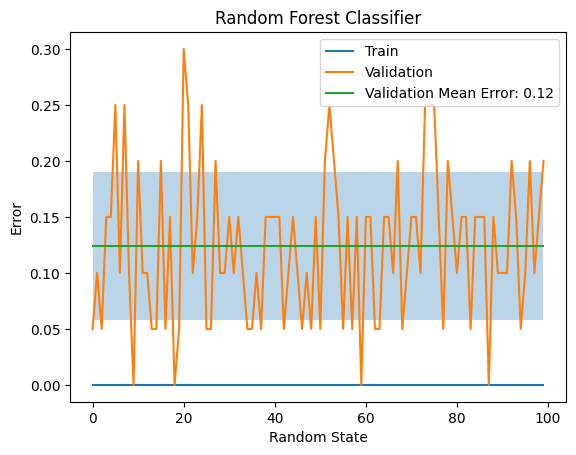

In [8]:
K = 100
train_errors = []
val_errors = []
for i in range(K):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=i)
    model = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=10)
    model.fit(X_train, y_train)
    train_errors.append(1 - model.score(X_train, y_train))
    val_errors.append(1 - model.score(X_val, y_val))

mean_val_error = np.mean(val_errors)
std_val_error = np.std(val_errors)
fig = plt.figure()
plt.plot(range(K), train_errors, label="Train")
plt.plot(range(K), val_errors, label="Validation")
plt.plot(range(K), [mean_val_error]*K, label=f"Validation Mean Error: {mean_val_error:.2f}")
plt.fill_between(range(K), [mean_val_error-std_val_error]*K, [mean_val_error+std_val_error]*K, alpha=0.3)
plt.title("Random Forest Classifier")
plt.xlabel("Random State")
plt.ylabel("Error")
plt.legend()
plt.show()

In [6]:
clf = RandomForestClassifier().fit(X, y)
print(clf.score(X, y))

1.0


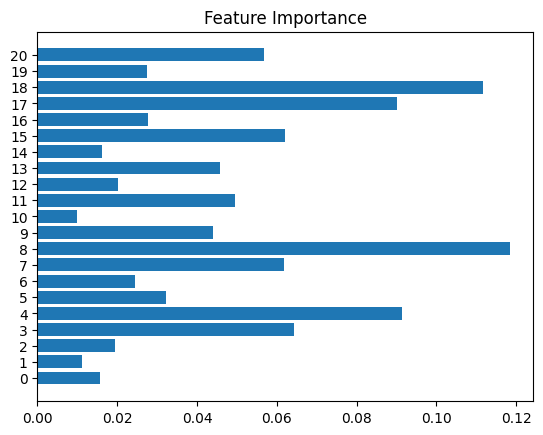

In [7]:
plt.figure()
plt.barh(range(X.shape[1]), clf.feature_importances_, align='center')
plt.yticks(range(X.shape[1]))
plt.title("Feature Importance");

Loaded 50 subjects
Creating features matrix


100%|██████████| 50/50 [00:40<00:00,  1.22it/s]


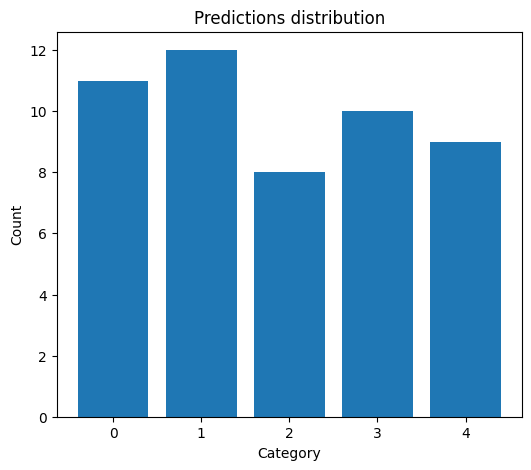

Submission file submission.csv created


In [8]:
submission(clf, "submission")

In [4]:
import cv2
from skimage import measure
from scipy.ndimage import distance_transform_edt

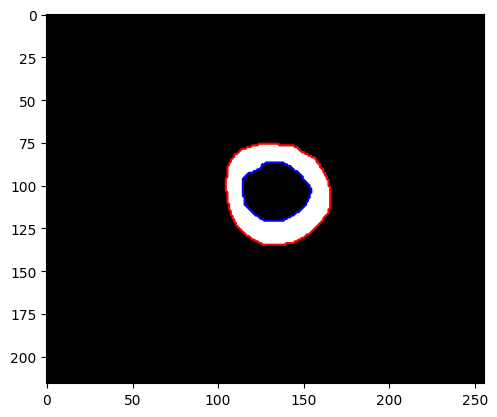

In [5]:
LVM_mask = (ft.get_ED_segmentation(25,dataset)[:,:,1] == 2).astype(np.uint8)

# Trouver les contours externes et internes du LVM
contours = measure.find_contours(LVM_mask, 0.5)
external_contour = max(contours, key=len)
internal_contours = min(contours, key=len)

plt.imshow(LVM_mask, cmap="gray")
plt.plot(external_contour[:,1], external_contour[:,0], c="r")
plt.plot(internal_contours[:,1], internal_contours[:,0], c="b")
plt.show()

